# Initialization

## Imports


In [1]:
# add src to path
from pyprojroot import here
import sys

sys.path.append(str(here("src")))

# import analysis_utils
from code.models import *
from code.analysis_utils import *

# load other libraries
from dotenv import load_dotenv
import logging
from pandas.errors import SettingWithCopyWarning

load_dotenv()

from code.make_figs import FigureGenerator

from code.analysis_pipeline import AnalysisPipeline

# suppress logging and warnings
import warnings

logging.getLogger("code.utils").setLevel(
    logging.WARNING
)  # suppress logging of dataset sizes from train_utils
logging.getLogger("code.models").setLevel(
    logging.WARNING
)  # suppress logging of model parameters from models.py
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# configure numpy and pytorch to print entire arrays/tensors
np.set_printoptions(threshold=np.inf)
torch.set_printoptions(threshold=torch.inf)

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


## Set up analysis pipeline


In [2]:
# choose variables to evaluate
CONTEXT_LENGTH_TO_EVAL = [128]
MLP_EXPANSION_FACTOR_TO_EVAL = [0.5, 1, 2, 4, 8, 12, 16, 24, 32]
NUM_DIMS_TO_EVAL = [8]
NUM_TASKS_TO_EVAL = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
SETTING = "categorical-sequence"
EXP_NAME = "mlp-titration-exp"


fixed_values = {
    "context_length": CONTEXT_LENGTH_TO_EVAL[0],
    "mlp_expansion_factor": MLP_EXPANSION_FACTOR_TO_EVAL[0],
    "num_dims": NUM_DIMS_TO_EVAL[0],
}

analysis_pipeline = AnalysisPipeline(
    setting=SETTING,
    exp_name=EXP_NAME,
    context_length_to_eval=CONTEXT_LENGTH_TO_EVAL,
    mlp_expansion_factor_to_eval=MLP_EXPANSION_FACTOR_TO_EVAL,
    num_dims_to_eval=NUM_DIMS_TO_EVAL,
)

experiment params:  {'setting': 'categorical-sequence', 'num_dims_lst': [8], 'num_tasks_lst': [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], 'context_length_lst': [128], 'mlp_expansion_factor_lst': [0.5, 1, 2, 4, 8, 12, 16, 24, 32], 'random_seed': 1, 'num_hidden_layers': 1, 'hidden_size': 64, 'batch_size': 64, 'learning_rate': 0.0005, 'max_steps': 100000, 'save_steps': [20, 58, 115, 193, 291, 408, 545, 703, 879, 1076, 1293, 1529, 1785, 2062, 2357, 2673, 3009, 3364, 3739, 4135, 4549, 4984, 5439, 5913, 6407, 6921, 7455, 8009, 8583, 9176, 9789, 10422, 11075, 11748, 12441, 13153, 13885, 14637, 15409, 16201, 17013, 17844, 18695, 19566, 20457, 21368, 22298, 23249, 24219, 25209, 26219, 27249, 28298, 29368, 30457, 31566, 32695, 33844, 35012, 36201, 37409, 38637, 39885, 41153, 42440, 43747, 45075, 46422, 47789, 49175, 50582, 52008, 53455, 54921, 56407, 57912, 59438, 60983, 62548, 64133, 65738, 67363, 69008, 70672, 72356, 74060, 75784, 77528, 79291, 81075, 82878, 84701, 86544, 88407, 90289

  0%|          | 0/9900 [00:00<?, ?it/s]

## Process data

In [3]:
algo_df = analysis_pipeline.process_algo_df(
    analysis_pipeline.algo_df_raw,
    num_dims_to_eval=NUM_DIMS_TO_EVAL,
    context_length_to_eval=CONTEXT_LENGTH_TO_EVAL,
    num_tasks_to_eval=NUM_TASKS_TO_EVAL,
    load_saved_evaluation=True,
)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [4]:
transformer_df_all_checkpoints = analysis_pipeline.process_transformer_df(
    analysis_pipeline.transformer_df_raw,
    algo_df=algo_df,
    num_dims_to_eval=NUM_DIMS_TO_EVAL,
    context_length_to_eval=CONTEXT_LENGTH_TO_EVAL,
    num_tasks_to_eval=NUM_TASKS_TO_EVAL,
    mlp_expansion_factor_to_eval=MLP_EXPANSION_FACTOR_TO_EVAL,
    load_saved_evaluation=True,
    compute_distance_from_algos=True,
)

transformer_df = find_approximate_interpolation_threshold(
    transformer_df_all_checkpoints, threshold_percentile=0.2
).query("included_in_interpolation_analysis == 1")

  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/9900 [00:00<?, ?it/s]

In [5]:
# Fit Bayesian model free params
param_combos = [
    {"context_length": cl, "mlp_expansion_factor": mlp, "num_dims": nd}
    for cl in CONTEXT_LENGTH_TO_EVAL
    for mlp in MLP_EXPANSION_FACTOR_TO_EVAL
    for nd in NUM_DIMS_TO_EVAL
]
models = []
for param_combo in param_combos:
    model_fitter = HierarchicalBayesianModelFitter(
        transformer_df=transformer_df,
        algo_df=algo_df,
        mlp_expansion_factor=param_combo["mlp_expansion_factor"],
        context_length=param_combo["context_length"],
        num_dims=param_combo["num_dims"],
        params_init=analysis_pipeline.params_init,
        metric_name=analysis_pipeline.metric_name,
        load_saved_evaluation=True,
        remove_last_prediction=analysis_pipeline.remove_last_prediction,
        add_to_df=True,
        baseline_lst=["optimal_constant_baseline"],
    )
    transformer_df, history, model = model_fitter.fit()
    models.append(model)

batch_size:  64
train_checkpoints: [  193   291   408   545   703   879  1076  1293  1529  1785  2062  2357
  2673  3009  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455
  8009  8583  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409
 16201 17013 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219
 27249 28298 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885
 41153 42440 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407
 57912 59438 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1067 [00:00<?, ?it/s]

batch_size:  64
train_checkpoints: [  291   408   545   703   879  1076  1293  1529  1785  2062  2357  2673
  3009  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455  8009
  8583  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409 16201
 17013 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219 27249
 28298 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885 41153
 42440 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407 57912
 59438 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1056 [00:00<?, ?it/s]

batch_size:  64
train_checkpoints: [  193   291   408   545   703   879  1076  1293  1529  1785  2062  2357
  2673  3009  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455
  8009  8583  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409
 16201 17013 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219
 27249 28298 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885
 41153 42440 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407
 57912 59438 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1067 [00:00<?, ?it/s]

batch_size:  64
train_checkpoints: [  193   291   408   545   703   879  1076  1293  1529  1785  2062  2357
  2673  3009  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455
  8009  8583  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409
 16201 17013 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219
 27249 28298 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885
 41153 42440 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407
 57912 59438 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1067 [00:00<?, ?it/s]

batch_size:  64
train_checkpoints: [  291   408   545   703   879  1076  1293  1529  1785  2062  2357  2673
  3009  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455  8009
  8583  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409 16201
 17013 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219 27249
 28298 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885 41153
 42440 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407 57912
 59438 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1056 [00:00<?, ?it/s]

batch_size:  64
train_checkpoints: [  408   545   703   879  1076  1293  1529  1785  2062  2357  2673  3009
  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455  8009  8583
  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409 16201 17013
 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219 27249 28298
 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885 41153 42440
 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407 57912 59438
 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1045 [00:00<?, ?it/s]

batch_size:  64
train_checkpoints: [  291   408   545   703   879  1076  1293  1529  1785  2062  2357  2673
  3009  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455  8009
  8583  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409 16201
 17013 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219 27249
 28298 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885 41153
 42440 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407 57912
 59438 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1056 [00:00<?, ?it/s]

batch_size:  64
train_checkpoints: [  408   545   703   879  1076  1293  1529  1785  2062  2357  2673  3009
  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455  8009  8583
  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409 16201 17013
 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219 27249 28298
 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885 41153 42440
 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407 57912 59438
 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1045 [00:00<?, ?it/s]

batch_size:  64
train_checkpoints: [  408   545   703   879  1076  1293  1529  1785  2062  2357  2673  3009
  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455  8009  8583
  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409 16201 17013
 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219 27249 28298
 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885 41153 42440
 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407 57912 59438
 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1045 [00:00<?, ?it/s]

# Analysis


#### MLP titration

In [6]:
transformer_df["bms_weights"] = transformer_df["bms_results"].apply(
    lambda x: x.get("weights", None)[0]
)

fig_gen_titration = FigureGenerator(
    transformer_df, transformer_df_all_checkpoints, algo_df, SETTING
)

mlp_factors_reduced = [1, 4, 32]
fig_gen_titration_reduced = FigureGenerator(
    transformer_df.query("mlp_expansion_factor in @mlp_factors_reduced"),
    transformer_df_all_checkpoints,
    algo_df,
    SETTING,
)

Registered Avenir font from: /sailhome/wurgaft/.fonts/Avenir.ttc
Registered Avenir font from: /sailhome/wurgaft/.fonts/Avenir.ttc


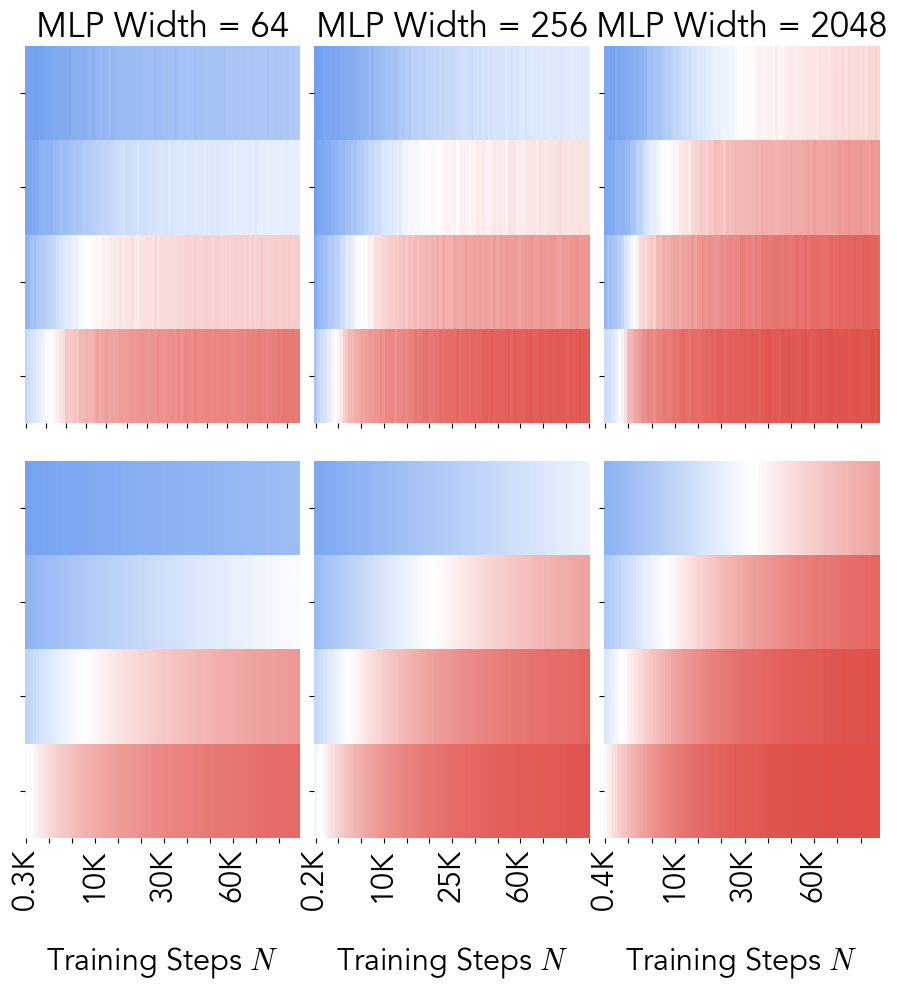

In [7]:
fig_gen_titration_reduced.generate_titration_plot(
    config={
        "col_names": ["relative_distance_train", "bms_weights"],
        "fixed_values": fixed_values,
        "mode": "train",
        "variable_config": {
            "fixed": ["context_length", "num_dims"],
            "iterate_over": ["checkpoint", "num_tasks"],
            "grid_by": "mlp_expansion_factor",
        },
        "hidden_size": analysis_pipeline.exp_params["hidden_size"],
    },
    show=True,
    save=False,
)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:meta dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'L', 'M', 'P', 'T', 'W', 'a', 'd', 'e', 'eight', 'five', 'four', 'h', 'i', 'k', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'v', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 10, 12, 29, 31, 42, 47, 55, 62, 96, 105, 110, 120, 123, 133, 136, 142, 143, 147, 149, 152, 153, 156, 163, 171, 176, 192, 195, 199, 204, 206, 211, 219, 221, 222, 228]
INFO:fontTools.subset:Closed glyph list over 

Saved figure to /sailhome/wurgaft/normative-icl/figures/categorical-sequence/free_parameter_titration_beta/free_parameter_titration_beta-categorical-sequence-grid_bymlp_expansion_factor.pdf


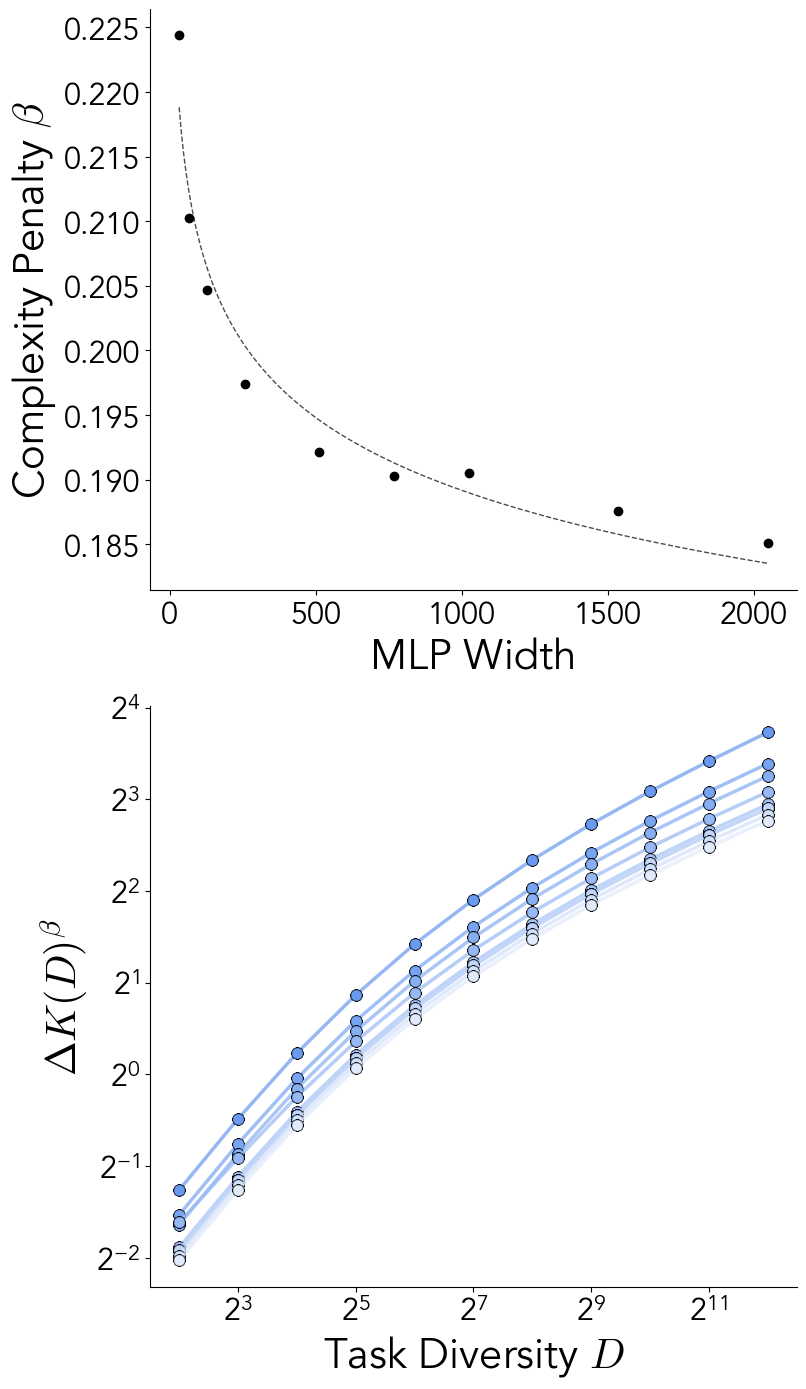

In [8]:
fig_gen_titration.generate_free_parameter_titration_plot(
    config={
        "param_name": "beta",
        "grid_by": "mlp_expansion_factor",
        "hidden_size": analysis_pipeline.exp_params["hidden_size"],
    },
    show=True,
    save=True,
)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:meta dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 34 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'E', 'L', 'M', 'P', 'S', 'T', 'W', 'a', 'd', 'e', 'five', 'four', 'g', 'h', 'i', 'k', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 13, 29, 31, 42, 45, 47, 55, 62, 96, 105, 120, 123, 125, 133, 136, 142, 143, 152, 156, 163, 171, 176, 192, 195, 199, 204, 206, 211, 221, 228]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 34 glyphs after
INFO:fontTools.subset:Glyph names: ['

Saved figure to /sailhome/wurgaft/normative-icl/figures/categorical-sequence/free_parameter_titration_alpha/free_parameter_titration_alpha-categorical-sequence-grid_bymlp_expansion_factor.pdf


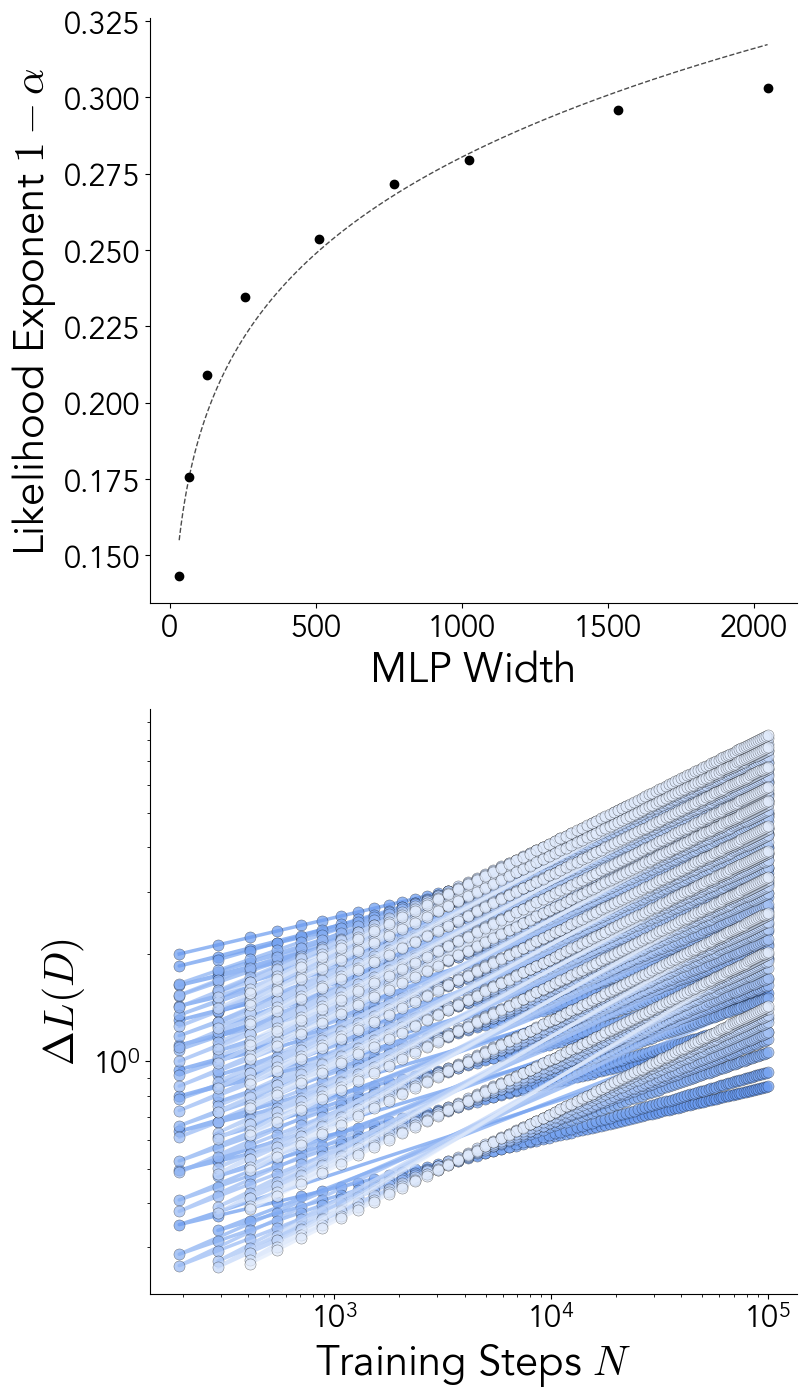

In [12]:
fig_gen_titration.generate_free_parameter_titration_plot(
    config={
        "param_name": "alpha",
        "grid_by": "mlp_expansion_factor",
        "hidden_size": analysis_pipeline.exp_params["hidden_size"],
    },
    show=True,
    save=True,
)